# Квазиньютоновские методы: между двух огней

## Как уменьшить сложность хранения и вычисления?

- Сложность вычисления можно уменьшить с помощью
    - Квазиньютоновские методы, они же методы переменной метрики
    - Требуется хранение матрицы $n \times n$
    
- Сложность вычисления и хранения можно уменьшить 
    - квазиньютоновские методы с ограниченной памятью, например [L-BFGS](https://en.wikipedia.org/wiki/Limited-memory_BFGS) (Limited Broyden-Fletcher-Goldfarb-Shanno)
    - НЕ требуется хранить матрицу
    - вместо этого хранятся $k \ll n$ векторов из $\mathbb{R}^n$

## Единообразный способ получения метода Ньютона и градиентного спуска 

- градиентный метод получен из аппроксимации первого порядка:

$$
f_G(x) \approx f(y) + \langle f'(y), x - y \rangle + \frac{1}{2}(x-y)^{\top} \frac{1}{\alpha}I(x - y)
$$

причём при $\alpha \in (0, 1/L], f(x) \leq f_G(x)$, то есть $f_G$ - глобальная оценка $f(x)$
- метод Ньютона получен из аппроксимации второго порядка

$$
f_N(x) \approx f(y) + \langle f'(y), x - y \rangle + \frac{1}{2} (x-y)^{\top}f''(y)(x-y)
$$

**Идея:** использовать промежуточную аппроксимацию вида

$$
f_q(x) \approx f(y) + \langle f'(y), x - y \rangle + \frac{1}{2} (x-y)^{\top}{\color{red}{B(y)}}(x-y),
$$

которая даёт переход к следующей точке:

$$
x_{k+1} = x_k - \alpha_k B^{-1}_k f'(x_k) = x_k - \alpha_k H_k f'(x_k)
$$

## Общая схема квазиньютоновских методов

```python
def QuasiNewtonMethod(f, x0, epsilon, **kwargs):
    
    x = x0
    
    H = I
    
    while True:
        
        h = -H.dot(grad_f(x))
        
        if StopCriterion(x, f, h, **kwargs) < epsilon:
            
            break
            
        alpha = SelectStepSize(x, h, f, **kwargs)
            
        x = x + alpha * h
            
        H = UpdateH(H, f(x), grad_f(x))
            
    return x
```

## DFP (Davidon-Fletcher-Powell)

$$
B_{k+1} = (I - \rho_k y_k s^{\top}_k)B_k(I - \rho_k s_ky^{\top}_k) + \rho_k y_k y^{\top}_k,
$$

где $\rho_k = \dfrac{1}{y^{\top}_k s_k}$,

или с помощью формулы Шермана-Морисона-Вудбери

$$
B^{-1}_{k+1} = H_{k+1} = H_k - \dfrac{H_ky_k y_k^{\top}H_k}{y^{\top}_kH_ky_k} + \dfrac{s_ks^{\top}_k}{y^{\top}_ks_k}
$$

**Вопрос:** какой ранг у разности матриц $B_{k+1} (H_{k+1})$ и $B_{k} (H_{k})$?

### Вывод

Общая идея квазиньютоновских методов: 

вместо полного пересчёта гессиана на каждой итерации обновлять 

текущую его аппроксимацию с помощью легко вычислимого 

преобразования

## BFGS

\begin{align*}
& \min_H \| H_k - H \| \\
\text{s.t. } & H = H^{\top}\\
& Hy_k = s_k
\end{align*}

Формула пересчёта для метода BFGS:

$$
H_{k+1} = (I - \rho_k s_ky^{\top}_k)H_k(I - \rho_k y_k s^{\top}_k) + \rho_k s_k s^{\top}_k,
$$

где $\rho_k = \dfrac{1}{y^{\top}_k s_k}$

### Детали реализации

- Не должно быть операций сложностью $O(n^3)$, то есть никаких матричных умножений и решений линейных систем (cf. [реализацию в SciPy v.0.18.1](https://github.com/scipy/scipy/blob/v0.18.1/scipy/optimize/optimize.py#L874-L976))
- Только правило Вольфа гарантирует соблюдения условия кривизны $y_k^{\top}s_k > 0$
- Параметры в правиле Вольфа обычно следующие
    - $\alpha_0 = 1$ необходим для сверхлинейной скорости
    - $\beta_1 = 10^{-4}$, $\beta_2 = 0.9$
- Способы инициализации $H_0$
    - единичная матрица
    - $H_0 = \frac{y_0^{\top}s_0}{y_0^{\top}y_0}I$ **после** первого шага, но до вычисления $H_1$.При вычислении $x_1$  используется $H_0 = I$
    - $H_0 = \delta \|g_0\|^{-1}_2 I$, параметр $\delta$ необходимо заранее задать
- При использовании $B$ вместо $H$ нужно хранить $B$ в виде $LDL^{\top}$ разложения и обновлять не саму матрицу $B$, а её разложение. Это явно делается за $O(n^2)$. Вычисление $h_k$ - это решение линейной системы с предвычисленным раздложением матрицы, следовательно сложность также $O(n^2)$. Этот подход позволяет контролировать устройчивость в диагонали матрицы $D$. На практике предпочтительнее работать с матрицей $H$


```python
def update_H(x_next, x_current):
    
    current_grad = grad(x_next)
    
    s = x_next - x_current
    
    y = current_grad - grad_mem[-1]
    
    rho = 1. / y.dot(s)
    
    if H is None:
        
        H = np.eye(x_current.shape[0]) / y.dot(y) / rho
        
    Hy = H.dot(y)
    
    Hys = np.outer(Hy, s)
    
    ss = np.outer(s, s)
    
    H = rho * ss + H - rho * Hys - rho * Hys.T + rho**2 * y.dot(Hy) * ss
    
    x_current = x_next
    
    return H
```

### Сходимость

**Теорема**

Пусть $f$ дважды непрерывно дифференцируема и её гессиан липшицев, также пусть последовательность генерируемая методом BFGS сходится к точке $x^*$ так что $\sum_{k=1}^{\infty} \|x_k - x^*\| < \infty$. Тогда $x_k \to x^*$ сверхлинейно.

### Самокоррекция

- Если BFGS на некоторой итерации даёт плохую оценку обратного гессиана, то через несколько итераций это недоразумение будет **автоматически** исправлено, то есть метод сам скорректирует грубую оценку гессиана
- Это свойство появляется только при правильном способе выбора шага, например при использовании правила Вольфа
- Метод DFP существенно хуже корректирует неточные оценки обратного гессиана
- Всё это будет ниже проиллюстрировано на примерах

## BFGS с ограниченной памятью (L-BFGS)

- В методе BFGS нужна не сама матрица $H$, а только функция умножения её на вектор 
- Поскольку требуется локальная оценка гессиана, старые значения векторов $s$ и $y$ могут портить текущую оценку

**Идея**

- Хранить $k \ll n$ последних векторов $s$ и $y$ - снижение требуемой памяти с $n^2$ до $kn$
- Выполнение умножения на вектор рекурсивно, без явного формирования матрицы $H$

```python
def get_lbfgs_direction(x):
    
    if H is None:
        
        current_grad = grad(x)
        
        return -current_grad
    
    else:
        
        q = current_grad
        
        alpha = np.zeros(len(s_hist))
        
        rho = np.zeros(len(s_hist))
        
        for i in range(len(s_hist) - 1, -1, -1):
            
            rho[i] = 1. / s_hist[i].dot(y_hist[i])
            
            alpha[i] = s_hist[i].dot(q) * rho[i]
            
            q = q - alpha[i] * y_hist[i]
            
        r = q * H
        
        for i in range(len(s_hist)):
            
            beta = rho[i] * y_hist[i].dot(r)
            
            r = r + s_hist[i] * (alpha[i] - beta)
            
    return -r

```

### Сравнение с нелинейным методом сопряжённых градиентов

- В методе Хестенса-Штифеля

$$
h_{k+1} = -f'(x_{k+1}) + \beta_{k+1} h_{k}, \quad \beta_{k+1} = \frac{y_k^{\top}f'(x_{k+1})}{y_k^{\top} h_k}
$$

или

$$
h_{k+1} = -\left(I - \frac{s_k y_k^{\top}}{y_k^{\top}s_k}\right)f'(x_{k+1}) = -\hat{H}_{k+1} f'(x_{k+1})
$$

- Матрица $\hat{H}_{k+1}$ несимметрична и неположительно определённая, однако матрица 

$$
H_{k+1} = \left(I - \frac{s_k y_k^{\top}}{y_k^{\top}s_k}\right)\left(I - \frac{y_k s_k^{\top}}{y_k^{\top}s_k}\right) + \frac{s_ks_k^{\top}}{y_k^{\top}s_k}
$$

удовлетворяет всем требованиям к матрице в методе BFGS и совпадает с формулой для обновления $H_k$, если $H_k = I$, то есть $k=1$ в методе LBFGS и $H_0 = I$
- Более того, при выборе шага по правилу наискорейшего спуска, формулы для метода Хестенса Штифеля и LBFGS с $k = 1$ в точности совпадают

## Barzilai-Borwein method

- Первая [статья](http://pages.cs.wisc.edu/~swright/726/handouts/barzilai-borwein.pdf) об этом методе опубликована в 1988, в журнале IMA Journal of Numerical Analysis
- [Статья](http://papers.nips.cc/paper/6286-barzilai-borwein-step-size-for-stochastic-gradient-descent.pdf) на NIPS 2016 о модификации этого метода в случае использования стохастической оценки градиента
- Идея: комбинация идеи наискорейшего спуска и квазиньютоновского метода

### Идея метода

- Наискорейший спуск: $x_{k+1} = x_k - \alpha_k f'(x_k)$, $\alpha_k = \arg \min\limits_{\alpha > 0} f(x_{k+1})$
- Метод Ньютона: $x_{k+1} = x_k - (f''(x_k))^{-1} f'(x_k)$
- Аппроксимация гессиана диагональной матрицей:

$$
\alpha_k f'(x_k) = \alpha_k I f'(x_k) = \left( \frac{1}{\alpha_k} I \right)^{-1} f'(x_k) \approx f''(x_k))^{-1} f'(x_k)
$$

- Как найти $\alpha_k$?

### Снова квазиньютоновское уравнение (Secant equation)
- Для точного гессиана
$$
f''(x_{k})(x_{k} - x_{k-1}) = f'(x_{k}) - f'(x_{k-1})
$$
- Для приближения

$$
\alpha_k^{-1} s_{k-1} \approx y_{k-1}
$$

- Задача аппроксимации одного вектора с помощью масштабирования другого
- Простейший квазиньютоновский метод вырождается в поиск оптимального шага

### Три способа найти $\alpha_k$

- Первый способ
    - Задача
    
    $$
    \min_{\beta} \|\beta s_{k-1} - y_{k-1} \|^2_2
    $$
    
    - Решение
    
    $$
    \alpha = \frac{1}{\beta} = \frac{s^{\top}_{k-1} s_{k-1}}{s^{\top}_{k-1} y_{k-1}}
    $$
    
- Второй способ
    - Задача
    
    $$
    \min_{\alpha} \| s_{k-1} - \alpha y_{k-1} \|^2_2
    $$
    
    - Решение
    
    $$
    \alpha = \frac{s^{\top}_{k-1} y_{k-1}}{y^{\top}_{k-1} y_{k-1}}
    $$
- Третий способ называется немонотонный линейный поиск: специальная модификация правил Армихо, учитывающая историю изменений значения функции, [статья](https://www.math.lsu.edu/~hozhang/papers/nonmonotone.pdf) 2004 г. в SIAM Journal on Optimization

## Эксперименты

### Поиск аналитического центра системы неравенств

$$
f(x) = - \sum_{i=1}^m \log(1 - a_i^{\top}x) - \sum\limits_{i = 1}^n \log (1 - x^2_i) \to \min_x
$$

In [1]:
import numpy as np
import liboptpy.unconstr_solvers as methods
import liboptpy.step_size as ss
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.optimize as scopt
plt.rc("text", usetex=True)

In [2]:
n = 3000
m = 100
x0 = np.zeros(n)
max_iter = 100
tol = 1e-5
A = np.random.rand(m, n) * 10

In [3]:
f = lambda x: -np.sum(np.log(1 - A.dot(x))) - np.sum(np.log(1 - x*x))
grad_f = lambda x: np.sum(A.T / (1 - A.dot(x)), axis=1) + 2 * x / (1 - np.power(x, 2))

In [4]:
def bb_method(f, gradf, x0, tol=1e-6, maxiter=100, callback=None, alpha_type=1):
    it = 0
    x_prev = x0.copy()
    current_tol = np.linalg.norm(gradf(x_prev))
    alpha = 1e-4
    while current_tol > tol and it < maxiter:
        it += 1
        current_grad = gradf(x_prev)
        if it != 1:
            g = current_grad - prev_grad
            if alpha_type == 1:
                alpha = g.dot(s) / g.dot(g)
            elif alpha_type == 2:
                alpha = s.dot(s) / g.dot(s)
        if callback:
            callback(x_prev)
        x_next = x_prev - alpha * current_grad
        current_tol = np.linalg.norm(gradf(x_next))
        prev_grad = current_grad
        s = x_next - x_prev
        x_prev = x_next
    if callback:
        callback(x_prev)
    return x_next

In [5]:
method = {
    "BB 1": methods.fo.BarzilaiBorweinMethod(f, grad_f, init_alpha=1e-4, type=1),
    "BFGS": methods.fo.BFGS(f, grad_f),
    "DFP": methods.fo.DFP(f, grad_f),
    "LBFGS": methods.fo.LBFGS(f, grad_f),
}

In [6]:
for m in method:
    print("\t Method {}".format(m))
    _ = method[m].solve(x0=x0, tol=tol, max_iter=max_iter, disp=True)

print("\t Method BFGS Scipy")
scopt_conv = []
scopt_res = scopt.minimize(f, x0, method="BFGS", jac=grad_f, callback=lambda x: scopt_conv.append(x), 
                           tol=tol, options={"maxiter": max_iter})
print("Result: {}".format(scopt_res.message))
if scopt_res.success:
    print("Convergence in {} iterations".format(scopt_res.nit))
print("Function value = {}".format(f(scopt_res.x)))

	 Method BB 1
Required tolerance achieved!
Convergence in 10 iterations
Function value = -706.5952809623045
Norm of gradient = 5.34264130475429e-06
	 Method BFGS


/Users/alex/anaconda3/envs/cvxpy/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


Required tolerance achieved!
Convergence in 24 iterations
Function value = -706.5952809622966
Norm of gradient = 6.928479420684621e-06
	 Method DFP
Maximum iteration exceeds!
Convergence in 100 iterations
Function value = -706.5950469552579
Norm of gradient = 0.03140781536901585
	 Method LBFGS
Required tolerance achieved!
Convergence in 8 iterations
Function value = -706.5952809623017
Norm of gradient = 5.766967682893029e-06
	 Method BFGS Scipy
Result: Optimization terminated successfully.
Convergence in 16 iterations
Function value = -706.5952809618987


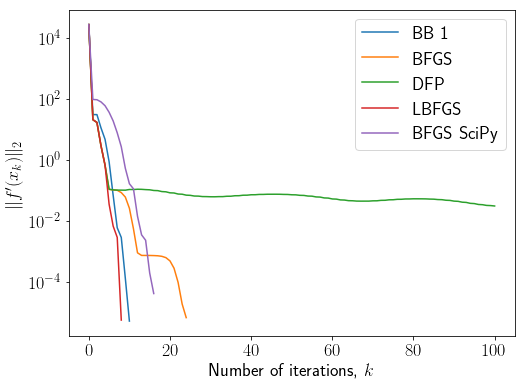

In [7]:
plt.figure(figsize=(8, 6))

for m in method:
    plt.semilogy([np.linalg.norm(grad_f(x)) for x in method[m].get_convergence()], label=m)

plt.semilogy([np.linalg.norm(grad_f(x)) for x in [x0] + scopt_conv], label="BFGS SciPy")
plt.ylabel("$\|f'(x_k)\|_2$", fontsize=18)
plt.xlabel("Number of iterations, $k$", fontsize=18)
plt.legend(fontsize=18)
plt.xticks(fontsize=18)
_ = plt.yticks(fontsize=18)

In [9]:
for m in method:
    print("\t Method {}".format(m))
    %timeit method[m].solve(x0=x0, tol=tol, max_iter=max_iter)

%timeit scopt.minimize(f, x0, method="BFGS", jac=grad_f, tol=tol, options={"maxiter": max_iter})

	 Method BB 1
6.03 ms ± 59.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
	 Method BFGS


/Users/alex/anaconda3/envs/cvxpy/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


5.82 s ± 231 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
	 Method DFP


/Users/alex/anaconda3/envs/cvxpy/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


10.2 s ± 100 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
	 Method LBFGS


/Users/alex/anaconda3/envs/cvxpy/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


28.5 ms ± 571 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
14.1 s ± 666 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Плохо обусловленная задача 

In [8]:
n = 50
D = np.arange(1, n+1)
U = np.random.randn(n, n)
U, _ = np.linalg.qr(U)
A = U.dot(np.diag(D)).dot(U.T)
b = np.random.randn(n)
eig_vals = np.linalg.eigvals(A)
print("Condition number = {}".format(np.max(eig_vals) / np.min(eig_vals)))

Condition number = 50.000000000000334


In [9]:
f = lambda x: 0.5 * x.T.dot(A.dot(x)) - b.dot(x)
gradf = lambda x: A.dot(x) - b
x0 = np.random.randn(n)

In [21]:
method = {
    "BB 1": methods.fo.BarzilaiBorweinMethod(f, gradf, init_alpha=1e-4, type=1),
    "BB 2": methods.fo.BarzilaiBorweinMethod(f, gradf, init_alpha=1e-4, type=2),
    "BFGS": methods.fo.BFGS(f, gradf),
    "DFP": methods.fo.DFP(f, gradf),
    "GD": methods.fo.GradientDescent(f, gradf, ss.ExactLineSearch4Quad(A, b)),
    "LBFGS": methods.fo.LBFGS(f, gradf, hist_size=10),
}

In [22]:
for m in method:
    print("\t Method {}".format(m))
    _ = method[m].solve(x0=x0, tol=tol, max_iter=max_iter, disp=True)

print("\t Method BFGS Scipy")

scopt_conv = []
scopt_res = scopt.minimize(f, x0, method="BFGS", jac=gradf, callback=lambda x: scopt_conv.append(x), 
                           tol=tol, options={"maxiter": max_iter})
print("Result: {}".format(scopt_res.message))
if scopt_res.success:
    print("Convergence in {} iterations".format(scopt_res.nit))
print("Function value = {}".format(f(scopt_res.x)))

	 Method BB 1
Required tolerance achieved!
Convergence in 62 iterations
Function value = -2.310714124536439
Norm of gradient = 5.976552870133477e-06
	 Method BB 2
Required tolerance achieved!
Convergence in 73 iterations
Function value = -2.310714124510319
Norm of gradient = 7.645687986275001e-06
	 Method BFGS
Required tolerance achieved!
Convergence in 46 iterations
Function value = -2.3107141245352274
Norm of gradient = 8.228357596394661e-06
	 Method DFP
Required tolerance achieved!
Convergence in 97 iterations
Function value = -2.3107141245360507
Norm of gradient = 8.385720237398356e-06
	 Method GD
Maximum iteration exceeds!
Convergence in 100 iterations
Function value = -2.3101833234570632
Norm of gradient = 0.04463472408731432
	 Method LBFGS
Required tolerance achieved!
Convergence in 46 iterations
Function value = -2.3107141245355973
Norm of gradient = 7.694823416577808e-06
	 Method BFGS Scipy
Result: Optimization terminated successfully.
Convergence in 59 iterations
Function val

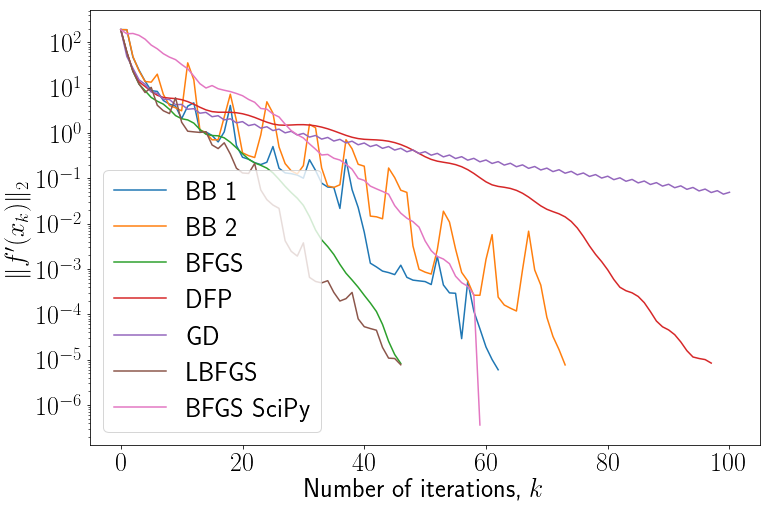

In [23]:
plt.figure(figsize=(12, 8))
fontsize = 26
for m in method:   
    plt.semilogy([np.linalg.norm(gradf(x)) for x in method[m].get_convergence()], label=m)

plt.semilogy([np.linalg.norm(gradf(x)) for x in [x0] + scopt_conv], label='BFGS SciPy')
plt.legend(fontsize=fontsize)
plt.ylabel("$\|f'(x_k)\|_2$", fontsize=fontsize)
plt.xlabel("Number of iterations, $k$", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)

## Pro & Contra

Pro:
1. Вместо **точного** вычисления гессиана используется его **оценка**, полученная с помощью градиента и оценки гессиана в предыдущей точке
2. Вместо решения систем линейных уравнений используется текущаю информация о функции и градиенте для аналитического вычисления приближения обращённого гессиана
3. Сложность одной итерации $O(n^2) + ...$ по сравнению с $O(n^3) + ...$ в методе Ньютона
4. Для метода L-BFGS требуется линейное количество памяти по размерности задачи
5. Свойство самокоррекции метода BFGS: если на некоторой итерации обратный гессиан оценен очень грубо, то следующие несколько итераций улучшат оценку
6. Сверхлинейная сходимость к решению задачи минимизации $f$ (подробнее см. [[1]](http://www.bioinfo.org.cn/~wangchao/maa/Numerical_Optimization.pdf))

Contra:
1. Нет универсального рецепта выбора начального приближения $B_0$ или $H_0$
2. Нет разработанной теории сходимости и оптимальности
3. Не любое условие на линейный поиск шага гарантирует выполнения условия кривизны $y^{\top}_ks_k > 0$